In [8]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(0, '../')


In [9]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm
tqdm.pandas()

import torch
from paule import models
import training
import testing
from paule import util

import time

import librosa
from  IPython.display import Audio
import IPython.display as ipd

In [10]:
train = pd.read_pickle("common_voice_oral_cavity_tube_norm_train.pkl")
valid = pd.read_pickle("common_voice_oral_cavity_tube_norm_valid.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'common_voice_oral_cavity_tube_norm_train.pkl'

In [4]:
label_vectors = pd.read_pickle("lexical_embedding_vectors.pkl")
vectors = np.asarray(list(label_vectors.vector))

FileNotFoundError: [Errno 2] No such file or directory: 'lexical_embedding_vectors.pkl'

In [ ]:
train.columns

In [6]:
column_input = "tube_norm"
column_output = "vector"

inps = train[column_input] 
tgts = train[column_output]
inps_valid = valid[column_input] 
tgts_valid = valid[column_output]

In [5]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
torch.manual_seed("24052022")

In [ ]:
model = ForwardModel(num_lstm_layers=1, 
                     hidden_size = 360,
                     output_size = 60,
                    input_size = 10,
                    apply_half_sequence=True).double().to(DEVICE)

In [9]:
model = EmbeddingModel(input_size = 10,num_lstm_layers=2,hidden_size=360,dropout=0.7,post_upsampling_size=0).double()
model.train()
model.to(DEVICE)

EmbeddingModel(
  (lstm): LSTM(10, 360, num_layers=2, batch_first=True, dropout=0.7)
  (linear_mapping): Linear(in_features=360, out_features=300, bias=True)
)

In [ ]:
model

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters in Model:", pytorch_total_params)

In [9]:
with open('model_tube_to_vector_model_2_720_0_dropout_07_noise_6e05_rmse_lr_00001_250.pkl', 'rb') as pfile:
    model, optimizer = pickle.load(pfile)
model.to(DEVICE)

EmbeddingModel(
  (lstm): LSTM(10, 720, num_layers=2, batch_first=True, dropout=0.7)
  (linear_mapping): Linear(in_features=720, out_features=300, bias=True)
)

In [12]:
torch.save(model.state_dict(),"/kaggle/working/" + "model_tube_to_mel_model_1_360_lr_0001_50_00001_100.pt")

In [ ]:
# reset learning rate in optimizer
learning_rate = 0.0001
for param_group in optimizer.param_groups:
    print(param_group['lr'])
    param_group['lr'] = learning_rate
    print(param_group['lr'])

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
print(0.001)
print(1e-4)

In [10]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
criterion = training.RMSELoss(eps=0)
#criterion = training.cp_trjacetory_rmse_pos_vel_acc_jerk_loss

In [11]:
num_epochs = 10000
continue_training_from = 250
batch_size = 8
seed = 24052022 #training.INV_FORW_SEED
save_model_after_i_iterations= 10

file_to_store = "tube_to_vector_model_2_720_0_dropout_07_noise_6e05_rmse_lr_00001" #"cp_to_tube_model_1_720_lr_0001_50_00001"#"cp_to_vector_model_2_720_0_dropout_07_noise_6e05_rmse_lr_00001
dict_file = "/kaggle/working"

In [12]:
#res_train = pd.DataFrame(columns=['epoch', 'loss', 'learning_rate'])
#res_valid = pd.DataFrame(columns=['epoch', 'loss', 'learning_rate'])
#res_train = pd.DataFrame(columns=['epoch', 'loss', 'position_loss', 'velocity_loss', 'acceleration_loss', 'jerk_loss','learning_rate'])
#res_valid = pd.DataFrame(columns=['epoch', 'loss', 'position_loss', 'velocity_loss', 'acceleration_loss', 'jerk_loss','learning_rate'])
res_train = pd.read_pickle("res_train_tube_to_vector_model_2_720_0_dropout_07_noise_6e05_rmse_lr_00001_250.pkl")
res_valid = pd.read_pickle("res_valid_tube_to_vector_model_2_720_0_dropout_07_noise_6e05_rmse_lr_00001_250.pkl")

In [ ]:
forward_training = training.Training(model, seed , inps, tgts, inps_valid, tgts_valid,
                 batch_size, res_train, res_valid, optimizer, criterion, use_same_size_batching = True)

In [13]:
embedder_training = training.Training(model, seed , 
                                     inps, tgts, inps_valid, tgts_valid,
                                     batch_size, res_train, res_valid, 
                                     optimizer, criterion, use_same_size_batching = True,
                                     use_cross_corr = False
                                    )

In [ ]:
start_time = time.time()
forward_training.train(num_epochs = num_epochs, 
                       continue_training_from=continue_training_from,
                       file_to_store = file_to_store, 
                       dict_file = dict_file, 
                       save_model_after_i_iterations = save_model_after_i_iterations)
print(time.time() - start_time)

In [ ]:
start_time = time.time()
forward_training.train(num_epochs = num_epochs, 
                       continue_training_from=continue_training_from,
                       file_to_store = file_to_store, 
                       dict_file = dict_file, 
                       save_model_after_i_iterations = save_model_after_i_iterations)
print(time.time() - start_time)

In [14]:
means = np.zeros(300)
stds = np.eye(300) * 6e-05

In [15]:
start_time = time.time()
embedder_training.train(num_epochs = num_epochs, 
                       continue_training_from=continue_training_from,
                       add_noise_to = "output",
                       mean_noise = means,
                       std_noise = stds,
                       fix_noise_per_epoch = False,
                       file_to_store = file_to_store, 
                       dict_file = dict_file, 
                       save_model_after_i_iterations = save_model_after_i_iterations)
print(time.time() - start_time)

Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.015277790007717522
Running Training Loss:  40.440310150428274


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006460604804661946


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.015089630385415647
Running Training Loss:  39.9422516301952


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.00643841904499199


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.015151673136082313
Running Training Loss:  40.1064787912099


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006403128030145697


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.015084609824728566
Running Training Loss:  39.92896220605645


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006542289591772018


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014996284893619297
Running Training Loss:  39.6951661134103


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006270792096433548


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014996976904351974
Running Training Loss:  39.69699786581956


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0065730900766869105


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014826389600418866
Running Training Loss:  39.24545327230869


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0064857561878128


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014892278842015329
Running Training Loss:  39.41986209481453


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006283271530423632


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014817172419141458
Running Training Loss:  39.221055393467495


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006341442360241457


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.0147746549838711
Running Training Loss:  39.10851174230685


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006622094927736141


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014755140135173398
Running Training Loss:  39.05685593780404


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0067628627113748676


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014739591064231618
Running Training Loss:  39.01569754702106


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0062731102575719145


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01476611600513608
Running Training Loss:  39.085909065595224


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006113938410966909


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014570480295763591
Running Training Loss:  38.568061342886224


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006134452566312428


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014538728088433104
Running Training Loss:  38.48401325008242


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006280118581058981


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014543209731588555
Running Training Loss:  38.49587615951494


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006148730954447886


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014495147245788145
Running Training Loss:  38.368654759601164


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006378844747601901


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014546613894405539
Running Training Loss:  38.5048869784915


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006183329626881565


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014382314295065247
Running Training Loss:  38.06998593903774


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.00626711530477157


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01443339781998494
Running Training Loss:  38.205204029500116


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0062435736941733435


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014498050456081194
Running Training Loss:  38.37633955724685


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006197817769601495


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014451700512193157
Running Training Loss:  38.253651255775324


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.00656028456020739


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014638770557843754
Running Training Loss:  38.74882566661244


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.015205475856471943


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014977488685566228
Running Training Loss:  39.6454125506938


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006161100860849279


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01425769525218032
Running Training Loss:  37.74011933252127


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.00606635679054501


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014232244939901155
Running Training Loss:  37.6727523559183


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006073115489338072


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014409501132405859
Running Training Loss:  38.14194949747824


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0060341627303924636


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014227174043006354
Running Training Loss:  37.65932969183778


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006356425883831016


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014191889786122984
Running Training Loss:  37.5659322638676


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0060409578079485505


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014141134701606071
Running Training Loss:  37.43158355515127


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006099258008366998


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014170167298980596
Running Training Loss:  37.50843284040161


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005993401575560371


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014238555981566103
Running Training Loss:  37.68945768320542


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006057743373720749


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01404633507548782
Running Training Loss:  37.18064894481631


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006053930736688483


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013994801377541785
Running Training Loss:  37.04423924635313


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006485499416194437


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01401843048399606
Running Training Loss:  37.1067854911376


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005933918178061937


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014005940246153028
Running Training Loss:  37.073723831567115


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006025844557914046


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013918830516286562
Running Training Loss:  36.84314437661047


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006017234319933347


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01388727839498017
Running Training Loss:  36.75962591151251


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005886339755564962


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013918544460915094
Running Training Loss:  36.84238718804229


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006155380860013232


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013860823341715798
Running Training Loss:  36.68959938552182


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006089042380104532


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013902417088491987
Running Training Loss:  36.799698033238364


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006091149868867905


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013917875997684192
Running Training Loss:  36.84061776587014


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005939397878527743


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014114141587628947
Running Training Loss:  37.3601327824538


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005816123496516602


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013701134083052862
Running Training Loss:  36.266901917840954


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005940419079434801


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013700295372381249
Running Training Loss:  36.264681850693194


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005941560799315717


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.014051922020375363
Running Training Loss:  37.19543758793362


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005940510501973675


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013582144478706924
Running Training Loss:  35.951936435137256


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0060056221376355605


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013662753103120087
Running Training Loss:  36.16530746395891


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006085826184121869


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013646524751657485
Running Training Loss:  36.12235101763736


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006150828361080572


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013883740316499723
Running Training Loss:  36.750260617774735


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0057020798598450655


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013451038488494977
Running Training Loss:  35.60489887904623


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005742787524732224


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013402950907382506
Running Training Loss:  35.47761105184152


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005739933284705222


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013550963631074622
Running Training Loss:  35.86940073145453


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005738952249987229


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013403594673080277
Running Training Loss:  35.47931509964353


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005673599102171735


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013652242547286688
Running Training Loss:  36.1374860226678


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006077457905547762


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01362663093365204
Running Training Loss:  36.069692081377006


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005779901551759704


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013574938900260599
Running Training Loss:  35.9328632689898


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005993380017497309


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013492537201847517
Running Training Loss:  35.714745973290455


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005689903923837353


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013316136273479339
Running Training Loss:  35.24781271589975


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0057318161060506126


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013353485979328688
Running Training Loss:  35.34667738728308


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005749444016613875


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013381852106282245
Running Training Loss:  35.421762525329136


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005723148080309901


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013325397459176425
Running Training Loss:  35.27232707444


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005704324022546039


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01333655752245297
Running Training Loss:  35.30186776193296


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005732399288579769


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013299477276384699
Running Training Loss:  35.20371635059019


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006107523883511393


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01339994004523837
Running Training Loss:  35.46964129974596


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005565781909120299


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01314029417382266
Running Training Loss:  34.7823586781086


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005663283537630932


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013261201107573417
Running Training Loss:  35.10239933174674


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.006004985273519444


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013144725789183085
Running Training Loss:  34.79408916396763


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0056527150087262775


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013068866339539704
Running Training Loss:  34.59328920076153


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005581109147533992


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013167078866141666
Running Training Loss:  34.85325775867692


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005763602457000177


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013162007650661337
Running Training Loss:  34.839834251300665


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005511006157383952


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013001697925993459
Running Training Loss:  34.41549441010471


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005561442658801295


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013222144734273035
Running Training Loss:  34.99901711162069


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005609622110697584


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013011679577164504
Running Training Loss:  34.44191584075447


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005533870921655621


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.01295509413762613
Running Training Loss:  34.29213418229635


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0057131848701150465


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013120061349769205
Running Training Loss:  34.72880239283906


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.00562350746012161


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013011672979560256
Running Training Loss:  34.441898376895985


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005553348196150049


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013110429731264686
Running Training Loss:  34.7033074986577


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.0056391261902034116


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.012872324946309223
Running Training Loss:  34.07304413288052


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005513152401553947


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]


Avg Training Loss:  0.013137050940864467
Running Training Loss:  34.773773840468245


Evaluating on Validation Set:   0%|          | 0/5096 [00:00<?, ?it/s]


Avg Validation Loss  0.005595371031465325


Batch...:   0%|          | 0/2647 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# reset learning rate in optimizer
learning_rate = 0.000001
for param_group in optimizer.param_groups:
    print(param_group['lr'])
    param_group['lr'] = learning_rate
    print(param_group['lr'])

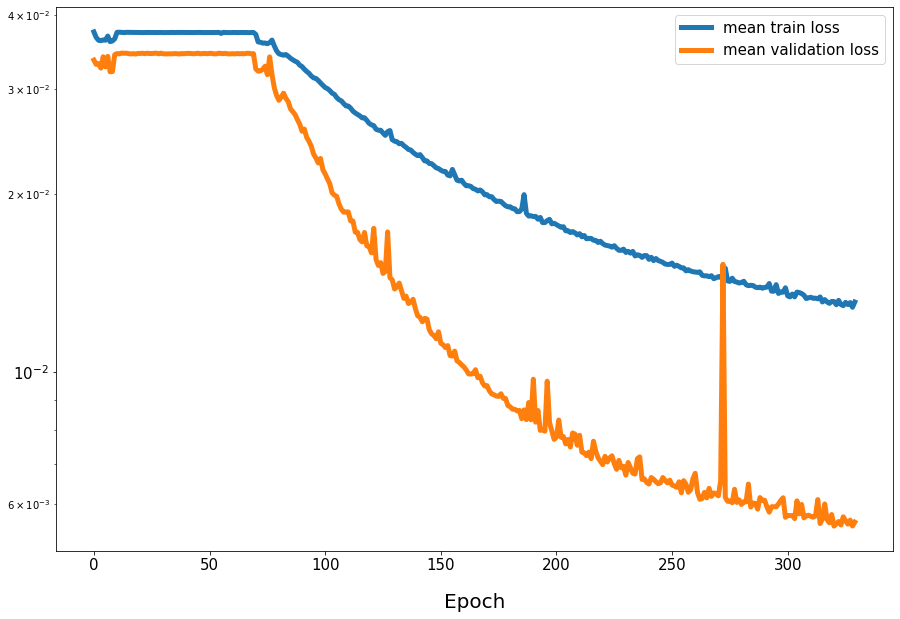

In [16]:
fig, ax = plt.subplots(figsize=(15, 10), facecolor="white")
tmp = res_train.groupby('epoch')['loss'].mean()
plt.semilogy(np.array(tmp.index), np.array(tmp), c='C0', lw=5, label='mean train loss')
del tmp
tmp = res_valid.iloc[1:].groupby('epoch')['loss'].mean()
plt.semilogy(np.array(tmp.index), np.array(tmp), c='C1', lw=5, label='mean validation loss')
ax.set_xlabel('Epoch', fontsize=20, labelpad=20)
#ax.set_ylabel('Loss (%s)' % str(loss_type), fontsize=20, labelpad=20)
ax.tick_params(axis='both', labelsize=15)
ax.legend(fontsize=15)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), facecolor="white")
tmp = res_train.groupby('epoch')['loss'].mean()
plt.semilogy(np.array(tmp.index), np.array(tmp), c='C0', lw=5, label='mean train loss')
del tmp
tmp = res_valid.iloc[1:].groupby('epoch')['loss'].mean()
plt.semilogy(np.array(tmp.index), np.array(tmp), c='C1', lw=5, label='mean validation loss')
ax.set_xlabel('Epoch', fontsize=20, labelpad=20)
#ax.set_ylabel('Loss (%s)' % str(loss_type), fontsize=20, labelpad=20)
ax.tick_params(axis='both', labelsize=15)
ax.legend(fontsize=15)

In [ ]:
res_valid

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), facecolor="white")
tmp = res_train.groupby('epoch')['loss'].mean()
plt.semilogy(np.array(tmp.index), np.array(tmp), c='C0', lw=5, label='mean train loss')
del tmp
tmp = res_valid.iloc[1:].groupby('epoch')['loss'].mean()
plt.semilogy(np.array(tmp.index), np.array(tmp), c='C1', lw=5, label='mean validation loss')
ax.set_xlabel('Epoch', fontsize=20, labelpad=20)
#ax.set_ylabel('Loss (%s)' % str(loss_type), fontsize=20, labelpad=20)
ax.tick_params(axis='both', labelsize=15)
ax.legend(fontsize=15)

In [ ]:
torch.save(model.state_dict(),"/kaggle/working/" + "%s.pt" % (file_to_store + "_%d" % 200))

In [ ]:
forward_training.res_train.to_pickle(dict_file + "res_train_" +file_to_store + "_%d.pkl" % num_epochs, protocol = 4)
forward_training.res_valid.to_pickle(dict_file + "res_valid_" + file_to_store + "_%d.pkl" % num_epochs, protocol = 4)